# Predicting County Graduation Rates w/ Socioeconomic & Library Access Data

## Introduction
High school graduation is a critical milestone that significantly impacts individual and community economic outcomes. Public libraries, as accessible hubs for educational resources, may play a vital role in supporting students, particularly in underserved communities.

This project investigates how library access and socioeconomic factors influence high school graduation rates across U.S. counties. Using ridge and lasso regression models, we analyze key predictors and provide insights that can inform policy decisions on education and library funding.

The analysis includes data from the American Community Survey (ACS), the Public Libraries Survey (PLS), and Small Area Income and Poverty Estimates (SAIPE). By examining patterns across all counties and specific subsets, this study highlights the importance of targeted resource allocation in improving educational outcomes.

## Data Import
- census_df --> SAIPE dataset
- graduation_df --> ACS dataset
- library_df --> PLS dataset

In [16]:
# import packages, files
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from urllib.request import urlopen
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

census_df = pd.read_excel('../Data/census_data.xls', sheet_name='est22ALL', skiprows=3, engine='xlrd')

graduation_df = pd.read_excel('../Data/graduation_rates.xlsx', sheet_name='Data')

library_df = pd.read_excel('../Data/library_data.xlsx', sheet_name='PLS_FY22_AE_pud22i')

## data cleaning
- align naming conventions across datasets
- deal with missing data
- transform metrics to per-capita for more relevant cross-county comparison

### alignment

In [17]:
# align dataframes for merging across counties
# using keys "state", "county"
# no trailing whitespace, all lowercase

# graduation file needs to have state extracted, words like "county" removed
# look at parish, city, planning area

# extract the state code as the last two characters
graduation_df['STATE'] = graduation_df['COUNTY'].str[-2:]

# remove the last four characters (", XX") from the COUNTY column
graduation_df['COUNTY'] = graduation_df['COUNTY'].str[:-4]

# consolidated regex for county naming conventions
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(
    r"\s*(County|City|Parish|Borough|Municipality|Planning Region|Census( Area)?)", "", 
    regex=True
).str.strip()

for col in graduation_df.columns:
    if graduation_df[col].dtype == 'object': 
        graduation_df[col] = graduation_df[col].str.lower().str.strip()
        
# library file needs to be made lowercase
library_df.rename(columns={'STABR': 'STATE', 'CNTY': 'COUNTY'}, inplace=True)
library_df['STATE'] = library_df['STATE'].str.lower().str.strip()
library_df['COUNTY'] = library_df['COUNTY'].str.lower().str.strip()

# map connecticut counties to correct names where possible
library_df.loc[library_df['STATE'] == 'CT', 'COUNTY'] = library_df.loc[library_df['STATE'] == 'CT', 'COUNTY'].replace({
    'litchfield': 'northwest hills',
    'hartford': 'capitol',
    'tolland': 'capitol',
    'windham': 'northeastern connecticut',
    'middlesex': 'lower connecticut river valley',
    'new london': 'southeastern connecticut'
})

# census file needs to have state extracted, words like "county" removed
census_df.rename(columns={'Postal Code': 'STATE', 'Name': 'COUNTY'}, inplace=True)
census_df['COUNTY'] = census_df['COUNTY'].str.replace(r"\s*(County|City|city|Parish|Borough|Municipality|Planning Region|Census( Area)?)", "", regex=True)

census_df['STATE'] = census_df['STATE'].str.lower().str.strip()
census_df['COUNTY'] = census_df['COUNTY'].str.lower().str.strip()

### select columns

In [18]:
# select and rename relevant columns before merging

graduation_df.columns = graduation_df.columns.astype(str)

graduation_df = graduation_df[['STATE', 'COUNTY', '2022-01-01 00:00:00']]
graduation_df.rename(columns={'2022-01-01 00:00:00': 'grad_rate'}, inplace=True)

library_df = library_df[['STATE', 'COUNTY', 'CNTYPOP', 'VISITS', 'REGBOR', 'TOTINCM', 'TOTPRO', 'TOTSTAFF', 'TOTCIR', 'CENTLIB', 'BRANLIB']]

# identify the columns to transform
columns_to_lower = library_df.columns[2:]  # From 'POPU_LSA' onwards

# convert these columns to lowercase
library_df.rename(columns={col: col.lower() for col in columns_to_lower}, inplace=True)

# drop blank columns

census_df = census_df[(census_df['90% CI Upper Bound.6'] != ".") & 
                      (census_df['90% CI Lower Bound.6'] != ".")]

# ensure columns are cast to float before subtraction
census_df['90% CI Upper Bound.6'] = census_df['90% CI Upper Bound.6'].astype(float)
census_df['90% CI Lower Bound.6'] = census_df['90% CI Lower Bound.6'].astype(float)

# create variable "income_range"
census_df['income_range'] = census_df['90% CI Upper Bound.6'] - census_df['90% CI Lower Bound.6']

census_df = census_df[['STATE', 'COUNTY', 'Poverty Percent, Age 5-17 in Families', 'Median Household Income', 'income_range', 'State FIPS Code', 'County FIPS Code']]

census_df['State FIPS Code'] = census_df['State FIPS Code'].apply(lambda x: str(x).zfill(2))

census_df['County FIPS Code'] = census_df['County FIPS Code'].apply(lambda x: str(x).zfill(3))

census_df['county_code'] = census_df['State FIPS Code'] + census_df['County FIPS Code']

census_df = census_df[['STATE', 'COUNTY', 'county_code', 'Poverty Percent, Age 5-17 in Families', 'Median Household Income', 'income_range']]

census_df.rename(columns={'Poverty Percent, Age 5-17 in Families':'poverty_percent', 'Median Household Income':'med_income'}, inplace=True)

### merge dataframes

In [19]:
# First, left join graduation_df (left) with library_df (right)
merged_df = graduation_df.merge(library_df, on=['STATE', 'COUNTY'], how='left')

# Then, left join the result with census_df (right)
merged_df = merged_df.merge(census_df, on=['STATE', 'COUNTY'], how='left')

# Select columns to convert (exclude 'STATE' and 'COUNTY')
columns_to_convert = merged_df.columns.difference(['STATE', 'COUNTY', 'county_code'])

# Convert selected columns to float
merged_df[columns_to_convert] = merged_df[columns_to_convert].astype(float)


### handle invalid data
#### first off, why is there missing data?
- county definitions vary depending on dataset (census standards vs state definitions). this causes a discrepancy in matches, especially for smaller, unincorporated counties 
#### why is there negative data?
- negative numbers are flags by the authors as missing data because of either being temporarily closed, are unavailable
- some states have lower reponse rates, marking all of their values as negative
- totpro (total programs) has a higher rate of negative values since no imputation methods for this variable were used


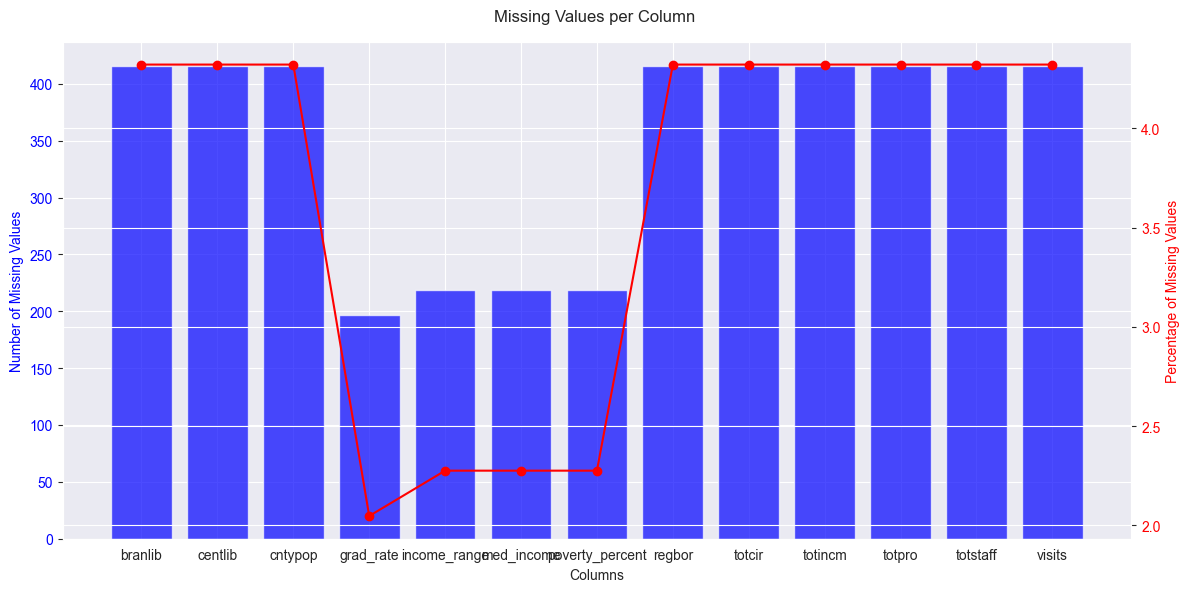

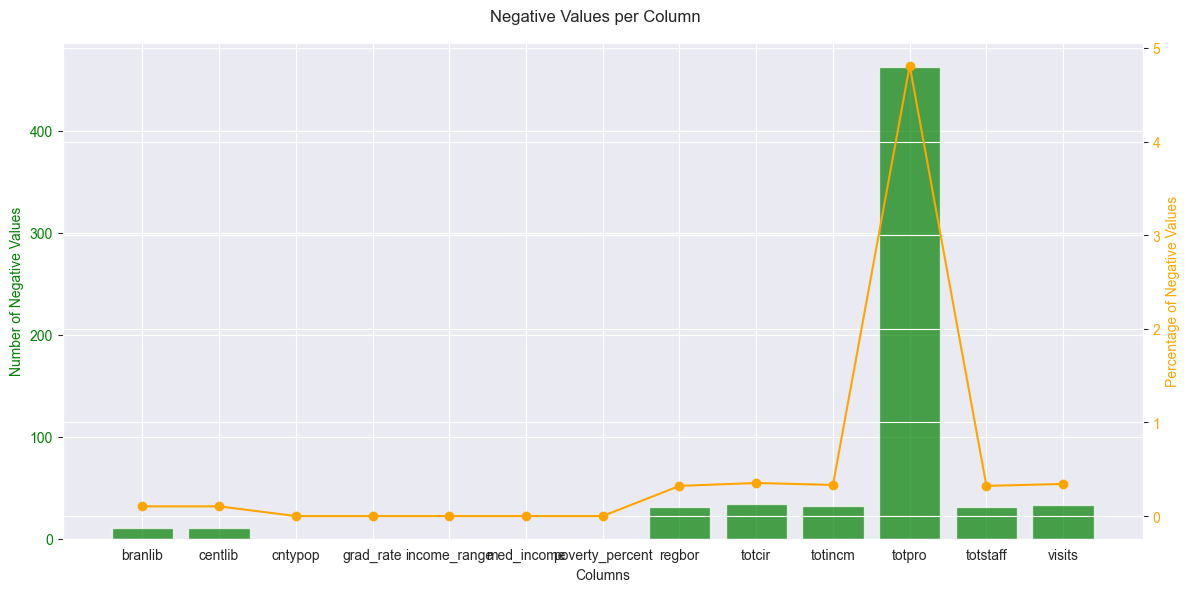

In [20]:
# Drop rows for Puerto Rico
merged_df = merged_df[merged_df['STATE'] != 'pr']

# Columns to check for missing or negative values
columns_to_check = merged_df.columns.difference(['STATE', 'COUNTY', 'county_code'])

# Calculate missing values
missing_counts = merged_df[columns_to_check].isnull().sum()
missing_percentages = (missing_counts / len(merged_df)) * 100

# Create dual y-axis bar graph for missing values
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for counts
ax1.bar(missing_counts.index, missing_counts.values, color='blue', alpha=0.7, label='Number of Missing Values')
ax1.set_xlabel("Columns")
ax1.set_ylabel("Number of Missing Values", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary y-axis for percentages
ax2 = ax1.twinx()
ax2.plot(missing_counts.index, missing_percentages.values, color='red', marker='o', label='Percentage of Missing Values')
ax2.set_ylabel("Percentage of Missing Values", color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle("Missing Values per Column")
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
plt.savefig("missing_values_dual_axis_plot.png")  # Save the plot as an image
plt.show()

# Calculate negative values
negative_counts = (merged_df[columns_to_check] < 0).sum()
negative_percentages = (negative_counts / len(merged_df)) * 100

# Create dual y-axis bar graph for negative values
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for counts
ax1.bar(negative_counts.index, negative_counts.values, color='green', alpha=0.7, label='Number of Negative Values')
ax1.set_xlabel("Columns")
ax1.set_ylabel("Number of Negative Values", color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Secondary y-axis for percentages
ax2 = ax1.twinx()
ax2.plot(negative_counts.index, negative_percentages.values, color='orange', marker='o', label='Percentage of Negative Values')
ax2.set_ylabel("Percentage of Negative Values", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

fig.suptitle("Negative Values per Column")
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
plt.savefig("negative_values_dual_axis_plot.png")  # Save the plot as an image
plt.show()


### data imputation
#### totpro:
- for totpro (total library programs), i've utilized a knn-imputer for cases where all the other library data is available
#### socioeconomic data:
- for socioeconomic data (poverty, income, income range), i've used the naive approach of imputing the median, since the focus of this project is primarily on the effects of library usage/availability

the remaining rows with missing data after these imputation steps are dropped

In [21]:
# Remove rows that are temporarily closed (values of -3)
filtered_df = merged_df[(merged_df != -3).all(axis=1)].copy()  # Create a copy to avoid warnings

# Print initial data types
print("Initial DataFrame data types:")
print(filtered_df.dtypes)
print("\n" + "="*50 + "\n")

# Impute for totpro using KNN

# Define the predictor columns (X) and target column (y)
X_columns = filtered_df.iloc[:, [3, 4, 5, 6, 8, 9, 10, 11]]

# Create masks for our conditions
valid_X = (X_columns >= 0).all(axis=1) & (~X_columns.isnull().any(axis=1))  # All X values are valid
missing_y = filtered_df.iloc[:, 7].isna() | (filtered_df.iloc[:, 7] < 0)    # Y is missing or negative

# Split data into training and prediction sets
train_mask = valid_X & ~missing_y  # Valid X and valid y for training
predict_mask = valid_X & missing_y  # Valid X but missing y for prediction

# Create training data
X_train = filtered_df[train_mask].iloc[:, [3, 4, 5, 6, 8, 9, 10, 11]]
y_train = filtered_df[train_mask].iloc[:, 7]

# Create prediction data (rows where we want to impute y)
X_predict = filtered_df[predict_mask].iloc[:, [3, 4, 5, 6, 8, 9, 10, 11]]

if len(X_predict) > 0:  # Only proceed if we have values to impute
    # Scale the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_predict_scaled = scaler.transform(X_predict)

    # Fit KNN on training data
    knn = KNNImputer(n_neighbors=5)
    # Add a dummy column for y to match the expected shape
    X_train_with_y = np.column_stack([X_train_scaled, y_train])
    knn.fit(X_train_with_y)
    
    # Predict missing y values
    X_predict_with_dummy = np.column_stack([
        X_predict_scaled, 
        np.full(len(X_predict_scaled), np.nan)
    ])
    imputed_values = knn.transform(X_predict_with_dummy)[:, -1]
    
    # Update only the rows where we have valid X but missing y
    filtered_df.loc[predict_mask, filtered_df.columns[7]] = imputed_values

print("KNN Imputation Results:")
print("Training set size:", sum(train_mask))
print("Number of values imputed:", sum(predict_mask))
print("\nSample of imputed values:")
if sum(predict_mask) > 0:
    print(filtered_df[predict_mask].iloc[:5, [7]])
print("\n" + "="*50 + "\n")

# impute for socioeconomic data using median values

# For socioeconomic data, use medians
socioeconomic_cols = ['poverty_percent', 'med_income', 'income_range']
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
filtered_df[socioeconomic_cols] = imp_median.fit_transform(filtered_df[socioeconomic_cols])

# Debug information before final filtering
print("Testing >= 0 comparison for each column:")
print("-" * 40)
for col in filtered_df.columns:
    try:
        result = filtered_df[col] >= 0
        print(f"✓ {col}")
    except TypeError:
        print(f"✗ {col} - TypeError")
        print(f"  Data type: {filtered_df[col].dtype}")
        print(f"  First few values: {filtered_df[col].head().tolist()}")
print("\n" + "="*50 + "\n")

# Get numeric columns
numeric_cols = filtered_df.select_dtypes(include=[np.number]).columns
print("Numeric columns that will be checked:")
print(numeric_cols.tolist())
print("\n" + "="*50 + "\n")

# Show shape before filtering
print("DataFrame shape before filtering:", filtered_df.shape)

# Remove remaining rows with negative or missing data only for numeric columns
filtered_df = filtered_df[filtered_df[numeric_cols].ge(0).all(axis=1)]

# Show shape after filtering
print("DataFrame shape after filtering:", filtered_df.shape)
print("Number of rows removed:", filtered_df.shape[0] - filtered_df.shape[0])

Initial DataFrame data types:
STATE               object
COUNTY              object
grad_rate          float64
cntypop            float64
visits             float64
regbor             float64
totincm            float64
totpro             float64
totstaff           float64
totcir             float64
centlib            float64
branlib            float64
county_code         object
poverty_percent    float64
med_income         float64
income_range       float64
dtype: object


KNN Imputation Results:
Training set size: 8740
Number of values imputed: 432

Sample of imputed values:
     totpro
118    26.0
229   128.8
231     8.0
254    31.2
256    13.8


Testing >= 0 comparison for each column:
----------------------------------------
✗ STATE - TypeError
  Data type: object
  First few values: ['al', 'al', 'al', 'al', 'al']
✗ COUNTY - TypeError
  Data type: object
  First few values: ['autauga', 'baldwin', 'baldwin', 'baldwin', 'baldwin']
✓ grad_rate
✓ cntypop
✓ visits
✓ regbor
✓ totincm
✓ t

### data aggregation

variables and description of how to handle multiplicity across counties (multiple library systems can exist for each county):
- STATE, COUNTY --> primary key
- grad_rate --> high school grad rate (%)
- cntypop --> population of county (should be same across)
- visits --> num visits in year (sum across library systems in county)
- regbor --> registered users (sum across all library systems in county? problem is people can be registered in more than one library)
- locgvt --> local government revenue (sum across? needs more analysis based off imputation methods)
- totpro --> total programs (sum across library systems)
- totstaff --> total staff (sum across library systems)
- totcir --> total circulation (sum across library systems in county)
- centlib --> num central libraries in system (sum across)
- branlib --> num bran libraries in systems (sum across)
- poverty_percent --> % in poverty in county (will be same across)
- med_income --> median household income (will be same across)
- income_range --> dif in 90% upper/lower CI of household income in county (will be same across)




In [22]:
# aggregate columns according to above

# Define aggregation logic for each column
aggregation_logic = {
    'county_code': 'first', # Same across rows
    'grad_rate': 'first',  # Average graduation rate
    'cntypop': 'first',  # Total population
    'visits': 'sum',  # Total visits across systems
    'regbor': 'sum',  # Total registered borrowers (note possible duplicates)
    'totincm': 'sum',  # Total revenues
    'totpro': 'sum',  # Total programs offered
    'totstaff': 'sum',  # Total staff across systems
    'totcir': 'sum',  # Total circulation
    'centlib': 'sum',  # Total number of central libraries
    'branlib': 'sum',  # Total number of branch libraries
    'poverty_percent': 'first',  # Same across rows, use first occurrence
    'med_income': 'first',  # Same across rows, use first occurrence
    'income_range': 'first'  # Same across rows, use first occurrence
}

# Group by STATE and COUNTY and apply aggregation logic
aggregated_df = filtered_df.groupby(['STATE', 'COUNTY'], as_index=False).agg(aggregation_logic)


### data transformation
- library data converted to per capita metrics using county populations for more relevant analysis and comparison

In [23]:
# Store original columns along with additional variables
columns_to_store = [
    'centlib', 'branlib', 'visits', 'regbor', 'totincm', 'totpro', 
    'totstaff', 'totcir', 'poverty_percent', 'med_income', 'income_range'
]
original_columns = aggregated_df[columns_to_store].copy()

# Retain cntypop for per capita conversion and future use
population_column = aggregated_df['cntypop'].copy()

# Convert to per capita by dividing each column by 'cntypop'
columns_to_convert = ['centlib', 'branlib', 'visits', 'regbor', 'totincm', 'totpro', 'totstaff', 'totcir']
for col in columns_to_convert:
    aggregated_df[col + '_per_capita'] = aggregated_df[col] / aggregated_df['cntypop']

# Drop the original columns
aggregated_df.drop(columns=columns_to_convert + ['cntypop'], inplace=True)

## exploratory data analysis
- identify interesting relationships among independent variables, as well as between independent variables and the dependent variable (the graduation rate)
- distinguish between top versus bottom performing counties

### county-level map
- our model will not be able to account for geographical dependencies 
- still important to visualize
- hover over a county to get its name, graduation, income, poverty, and library circulation per capita information 

In [24]:
# Load GeoJSON for US counties
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

# Create a separate DataFrame for the map
map_df = aggregated_df.dropna(subset=['county_code', 'grad_rate']).copy()

# Create the choropleth map
fig = px.choropleth(
    map_df,
    geojson=counties,       # GeoJSON file for US counties
    locations='county_code',       # Column with FIPS codes
    color='grad_rate',      # Column with graduation rates
    hover_name='COUNTY',
    hover_data={'grad_rate': True, 'med_income': True, 'poverty_percent': True, "totcir_per_capita": True},
    color_continuous_scale="RdYlGn",  # Color scheme
    range_color=(50, 100),   # Graduation rates range from >50 to ~100
    scope="usa",            # Show only the USA
    labels={'grad_rate': 'Graduation Rate (%)'}  # Legend label
)

# Adjust layout
fig.update_layout(
    title="USA Graduation Rates by County",
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

# download the map
pio.write_html(fig, file="grad_rate_by_counties.html")

### distribution of independent variables
- compare distribution of the variables, especially wrt to whether county is top/middle/bottom performing in grad rates
- notable insights include the differing distribution of socioeconomic levels, and similarity of library data across grad rate level

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


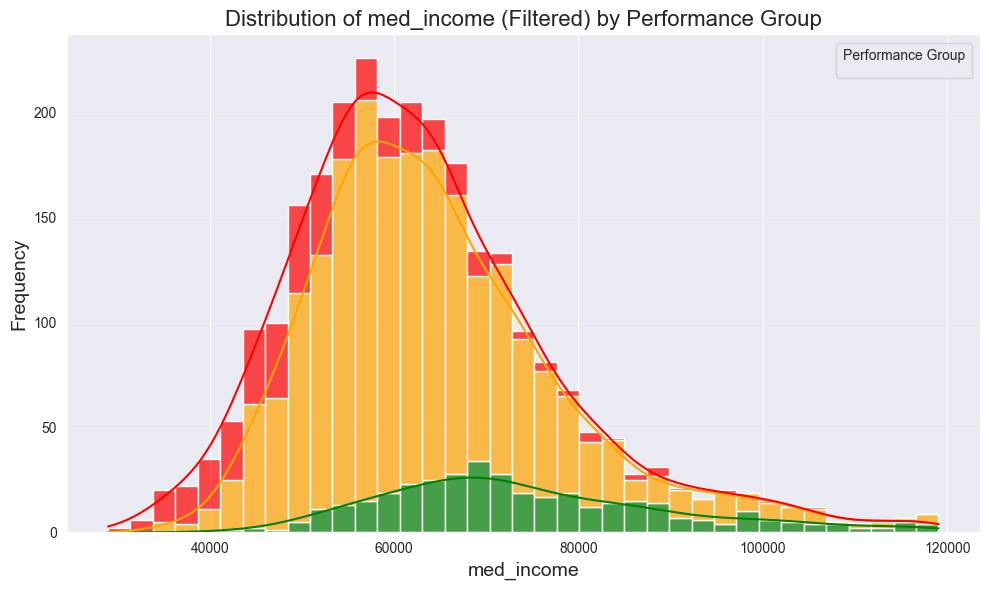

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


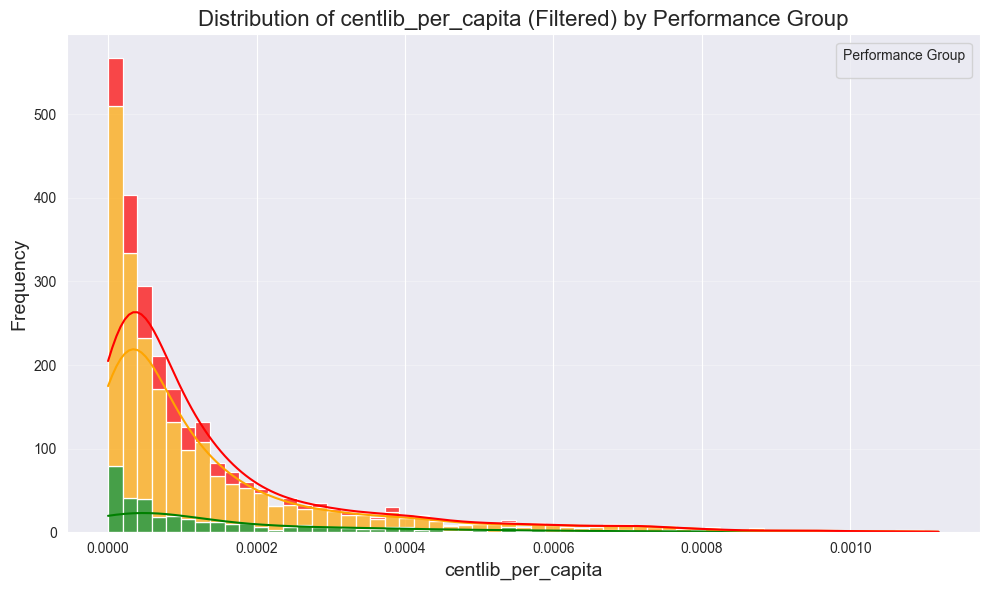

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


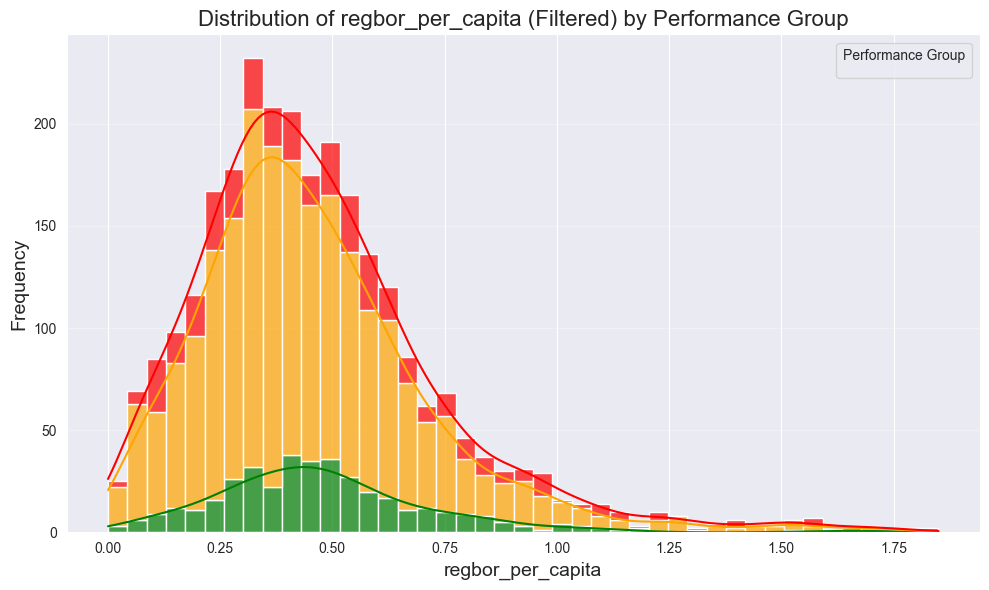

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


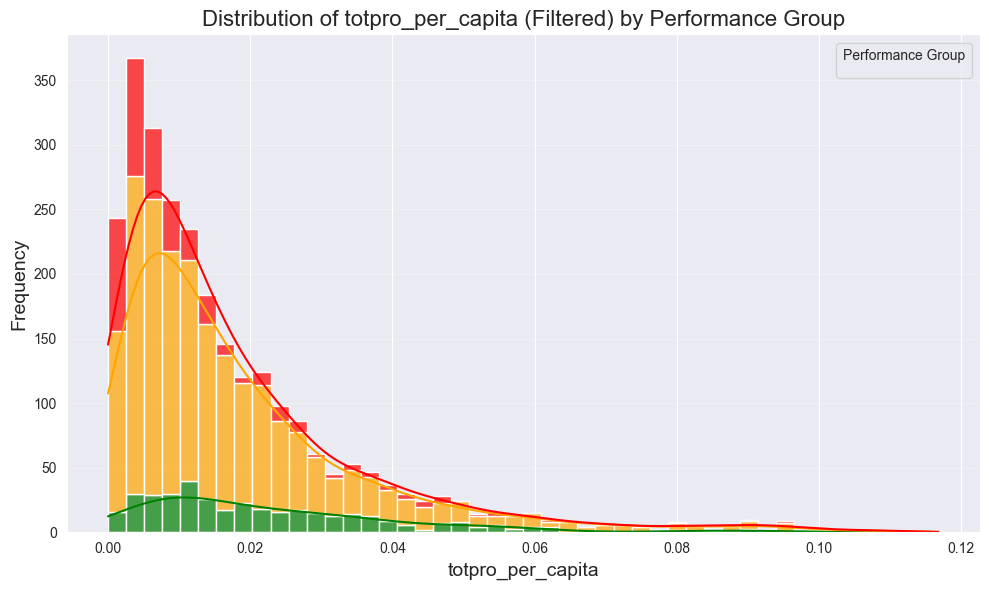

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


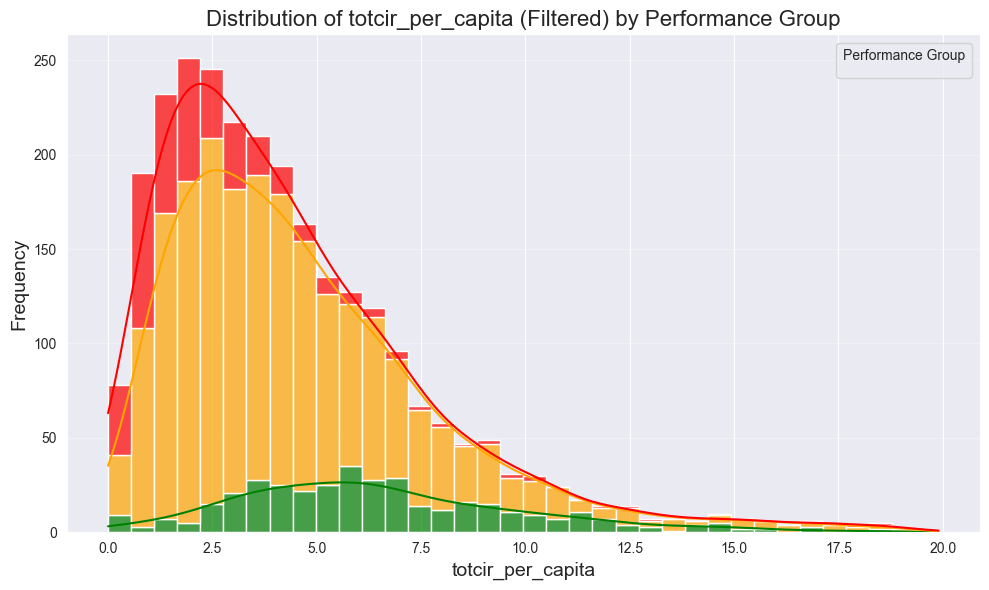

In [25]:
# Define thresholds for top, middle, bottom groups
threshold = 0.15  # Define top/bottom 15%
top_threshold = aggregated_df['grad_rate'].quantile(1 - threshold)
bottom_threshold = aggregated_df['grad_rate'].quantile(threshold)

# Create a new column for performance groups
aggregated_df['performance_group'] = pd.cut(
    aggregated_df['grad_rate'],
    bins=[-float('inf'), bottom_threshold, top_threshold, float('inf')],
    labels=['Bottom', 'Middle', 'Top']
)


# Identify the independent variables (exclude target and grouping columns)
independent_vars = aggregated_df.drop(columns=['grad_rate', 'performance_group', 'county_code', 'STATE', 'COUNTY']).columns

# Loop through each variable and create filtered plots
for var in independent_vars:
    # Filter out extreme outliers for the current variable
    threshold = aggregated_df[var].quantile(0.99)  # Keep only 99% of the data
    filtered_df = aggregated_df[aggregated_df[var] <= threshold]

    # Plot the filtered variable by performance group
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=filtered_df,
        x=var,
        hue='performance_group',
        multiple='stack',  # Stack the groups
        palette={'Top': 'green', 'Middle': 'orange', 'Bottom': 'red'},
        kde=True,          # Add density curve
        alpha=0.7          # Transparency for readability
    )
    plt.title(f'Distribution of {var} (Filtered) by Performance Group', fontsize=16)
    plt.xlabel(var, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(title='Performance Group', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

### correlation matrices
- examine correlations between variables
- correlations change based off of graduation performance, suggesting there may be potential non-linearity between independent and dependent variables
- library variables like funding, circulation, and visits tend to be moderately correlated with each other

C:\Users\Chris\AppData\Local\Temp\ipykernel_35348\3183238829.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\Chris\AppData\Local\Temp\ipykernel_35348\3183238829.py:8: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\Chris\AppData\Local\Temp\ipykernel_35348\3183238829.py:9: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



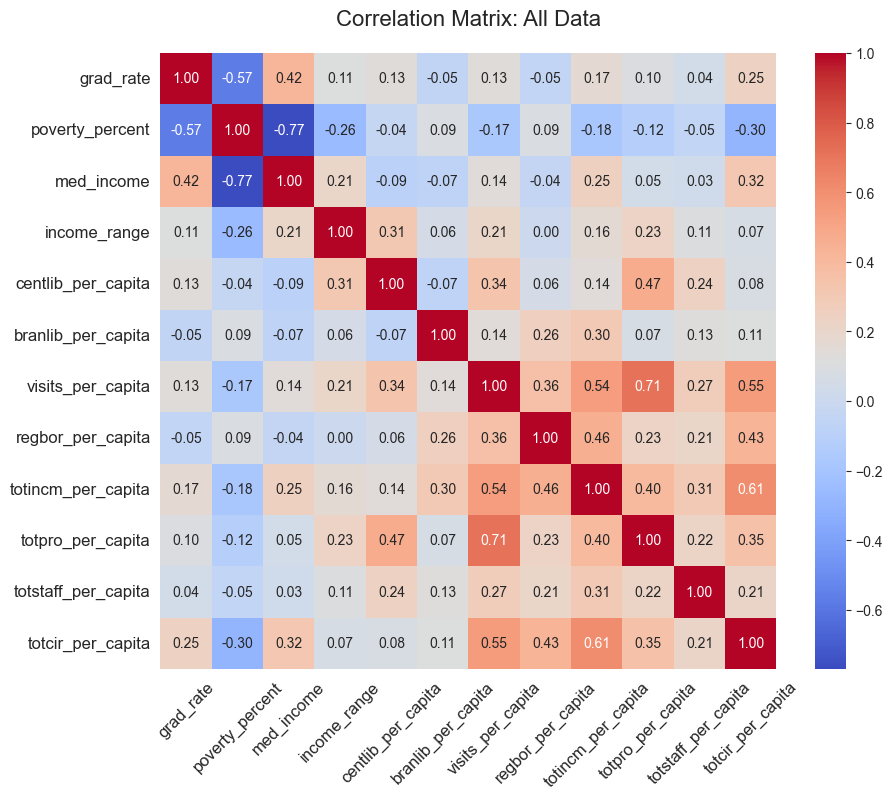

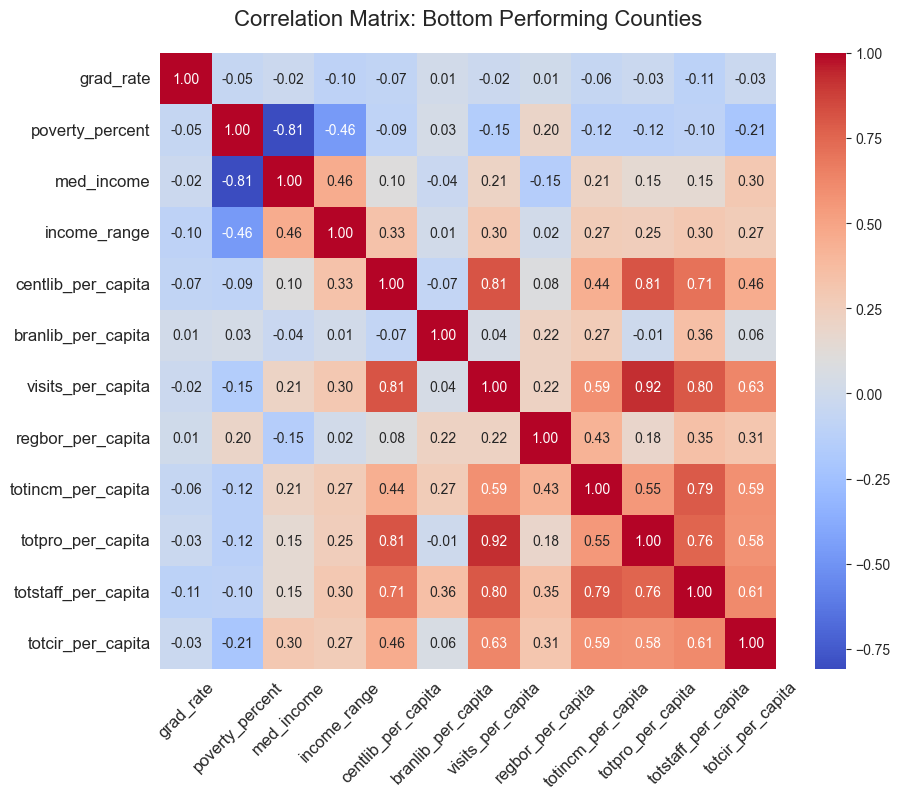

In [26]:
# Compute correlation matrices
full_corr = aggregated_df.corr()

# Filter data for top and bottom groups
top_data = aggregated_df[aggregated_df['performance_group'] == 'Top']
bottom_data = aggregated_df[aggregated_df['performance_group'] == 'Bottom']

top_corr = top_data.corr()
bottom_corr = bottom_data.corr()

# Function to plot correlation matrix using Seaborn
def plot_correlation_matrix(corr_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix, 
        annot=True,           # Display correlation values
        fmt=".2f",            # Format numbers to 2 decimal places
        cmap="coolwarm",      # Color scheme
        cbar=True,            # Show color bar
        square=True           # Keep heatmap square
    )
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# Plot correlation matrices
plot_correlation_matrix(full_corr, "Correlation Matrix: All Data")
plot_correlation_matrix(top_corr, "Correlation Matrix: Top Performing Counties")
plot_correlation_matrix(bottom_corr, "Correlation Matrix: Bottom Performing Counties")

### independent variables vs grad rate scatterplots
- preliminary examination of visual trends between independent variables and the graduation rate by county
- trends are most apparent for the socioeconomic variable
- variability seems to be visibly correlated wih the graduation rate (e.g. the variability of the poverty rate increases as grad rates decrease); heteroscedastic

In [27]:
# Exclude the dependent variable and grouping columns from the list of independent variables
independent_vars = aggregated_df.drop(columns=['grad_rate', 'STATE', 'COUNTY', 'county_code', 'performance_group']).columns

# Loop through independent variables and create scatter plots
for var in independent_vars:
    fig = px.scatter(
        aggregated_df,
        x=var,
        y='grad_rate',
        color='performance_group',
        color_discrete_map={'Top': 'green', 'Middle': 'orange', 'Bottom': 'red'},  # Optional color scheme
        render_mode='svg',
        title=f'Grad Rate (%) vs {var}',
        labels={var: var, 'grad_rate': 'Grad Rate (%)', 'performance_group': 'Performance Group'},
        hover_data=['STATE', 'COUNTY'],  # Additional hover information
        opacity=0.3
    )

    # Update layout for better readability
    fig.update_layout(
        title_x=0.5,  # Center the title
        xaxis_title=var,
        yaxis_title='Grad Rate (%)',
        legend_title="Performance Group",
        height=600,
        width=800
    )

    fig.show()

## model building
### baseline
- for the different groups of data (all/top/bottom counties), the mean of graduation rates among the counties is used as a baseline for evaluating the mse
### lasso/ridge
- 80/20 training-test split
- lasso and ridge regressions are used to shrink irrelevant variables towards zero
- data is standardized prior to regression to accommodate the nature of regularization
- regularization penalty selected with cross-validation
### visualizations
- actual values versus predicted values for the test sets
- comparisons of model weights by variable
- comparisons of mean squared error of the different predictors (lasso/ridge/mean)
 

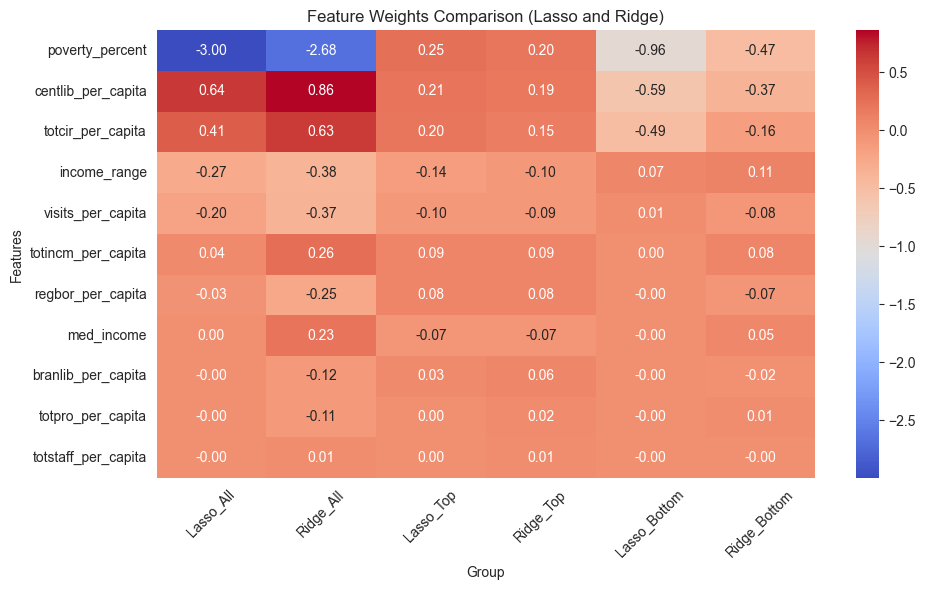

In [28]:
def plot_actual_vs_predicted_plotly(actual, predicted, group_name, state, county):
    """
    Create an interactive scatter plot comparing actual vs predicted values using Plotly.
    """
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Actual': actual,
        'Predicted': predicted,
        'State': state,
        'County': county
    })

    # Create the scatter plot
    fig = px.scatter(
        plot_df,
        x='Actual',
        y='Predicted',
        hover_data={'State': True, 'County': True},
        title=f"Actual vs Predicted Graduation Rates ({group_name})",
        labels={'Actual': 'Actual Graduation Rates', 'Predicted': 'Predicted Graduation Rates'},
        opacity=0.7
    )

    # Add a reference line for perfect prediction (y = x)
    fig.add_shape(
        type="line",
        x0=min(actual),
        y0=min(actual),
        x1=max(actual),
        y1=max(actual),
        line=dict(color="red", dash="dash"),
        name="Perfect Prediction"
    )

    # Update layout for better readability
    fig.update_layout(
        title_x=0.5,  # Center the title
        height=600,
        width=800
    )

    fig.show()


def visualize_results(weight_data, error_data):
    """Create visualizations for feature weights and train/test errors"""
    # Feature weights heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(weight_data, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Feature Weights Comparison (Lasso and Ridge)")
    plt.xlabel("Group")
    plt.ylabel("Features")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Train/Test errors heatmap
    plt.figure(figsize=(8, 4))
    sns.heatmap(error_data, annot=True, fmt=".4f", cmap="Blues", cbar=True)
    plt.title("Train/Test Errors Comparison (Lasso, Ridge, and Mean)")
    plt.xlabel("Metric")
    plt.ylabel("Counties")
    plt.tight_layout()
    plt.show()

def train_and_evaluate(X, y, model_type="Lasso"):
    """
    Train and evaluate either Lasso or Ridge regression model.
    Returns a tuple of (train_error, test_error, coefficients_df, residuals, test_pred, y_test)
    """
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the model
    if model_type == "Lasso":
        model = LassoCV(alphas=np.logspace(-4, 4, 100), cv=20, random_state=42)
    else:  # Ridge
        model = RidgeCV(alphas=np.logspace(-4, 4, 100), scoring='neg_mean_squared_error', cv=20)
    
    # Calculate error for benchmark 
    y_train_mean = y_train.mean()
    benchmark_train = np.full_like(y_train, y_train_mean)
    benchmark_pred = np.full_like(y_test, y_train_mean)
    benchmark_train_mse = mean_squared_error(y_train, benchmark_train)
    benchmark_test_mse = mean_squared_error(y_test, benchmark_pred)
    
    
    # Create and fit pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)

    # Get the fitted regressor
    regressor = pipeline.named_steps['regressor']

    # Calculate predictions and errors
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)
    train_error = mean_squared_error(y_train, train_pred)
    test_error = mean_squared_error(y_test, test_pred)

    # Calculate residuals
    train_residuals = y_train - train_pred
    test_residuals = y_test - test_pred

    # Create coefficients DataFrame
    coefficients = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': regressor.coef_
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    return train_error, test_error, coefficients, test_residuals, test_pred, y_test, train_residuals, benchmark_train_mse, benchmark_test_mse

def run_analysis(aggregated_df):
    """Run complete regression analysis on all data subsets."""
    # Prepare full dataset
    X_all = aggregated_df.drop(columns=['STATE', 'COUNTY', 'grad_rate', 'performance_group', 'county_code'])
    X_all = X_all.select_dtypes(include=np.number)
    y_all = aggregated_df['grad_rate']
    independent_vars = X_all.columns  # Store for residual analysis

    # Storage for visualizations
    feature_weights = pd.DataFrame()
    errors = pd.DataFrame()

    # Full dataset analysis
    lasso_all = train_and_evaluate(X_all, y_all, "Lasso")
    ridge_all = train_and_evaluate(X_all, y_all, "Ridge")
    
    # Plot actual vs predicted
    y_test_all, y_pred_all = lasso_all[5], lasso_all[4]
    state_all = aggregated_df['STATE'].loc[y_test_all.index]
    county_all = aggregated_df['COUNTY'].loc[y_test_all.index]
    plot_actual_vs_predicted_plotly(y_test_all, y_pred_all, "All Counties", state_all, county_all)
    
    # Store results for all counties
    feature_weights["Lasso_All"] = lasso_all[2]['Coefficient'].values
    feature_weights["Ridge_All"] = ridge_all[2]['Coefficient'].values
    errors.loc["All", "Lasso_Train"] = lasso_all[0]
    errors.loc["All", "Lasso_Test"] = lasso_all[1]
    errors.loc["All", "Ridge_Train"] = ridge_all[0]
    errors.loc["All", "Ridge_Test"] = ridge_all[1]
    errors.loc["All", "Benchmark_Train"] = lasso_all[7]
    errors.loc["All", "Benchmark_Test"] = lasso_all[8]
    
    top_data = aggregated_df[aggregated_df['performance_group'] == 'Top']
    X_top = top_data.drop(columns=['STATE', 'COUNTY', 'grad_rate', 'performance_group', 'county_code'])
    X_top = X_top.select_dtypes(include=np.number)
    y_top = top_data['grad_rate']
    
    lasso_top = train_and_evaluate(X_top, y_top, "Lasso")
    ridge_top = train_and_evaluate(X_top, y_top, "Ridge")
    
    # Plot actual vs predicted for top counties
    y_test_top, y_pred_top = lasso_top[5], lasso_top[4]
    state_top = top_data['STATE'].loc[y_test_top.index]
    county_top = top_data['COUNTY'].loc[y_test_top.index]
    plot_actual_vs_predicted_plotly(y_test_top, y_pred_top, "Top Counties", state_top, county_top)
    
    # Store results for top counties
    feature_weights["Lasso_Top"] = lasso_top[2]['Coefficient'].values
    feature_weights["Ridge_Top"] = ridge_top[2]['Coefficient'].values
    errors.loc["Top", "Lasso_Train"] = lasso_top[0]
    errors.loc["Top", "Lasso_Test"] = lasso_top[1]
    errors.loc["Top", "Ridge_Train"] = ridge_top[0]
    errors.loc["Top", "Ridge_Test"] = ridge_top[1]
    errors.loc["Top", "Benchmark_Train"] = lasso_top[7]
    errors.loc["Top", "Benchmark_Test"] = lasso_top[8]

    bottom_data = aggregated_df[aggregated_df['performance_group'] == 'Bottom']
    X_bottom = bottom_data.drop(columns=['STATE', 'COUNTY', 'grad_rate', 'performance_group', 'county_code'])
    X_bottom = X_bottom.select_dtypes(include=np.number)
    y_bottom = bottom_data['grad_rate']
    
    lasso_bottom = train_and_evaluate(X_bottom, y_bottom, "Lasso")
    ridge_bottom = train_and_evaluate(X_bottom, y_bottom, "Ridge")
    
    # Plot actual vs predicted for bottom counties
    y_test_bottom, y_pred_bottom = lasso_bottom[5], lasso_bottom[4]
    state_bottom = bottom_data['STATE'].loc[y_test_bottom.index]
    county_bottom = bottom_data['COUNTY'].loc[y_test_bottom.index]
    plot_actual_vs_predicted_plotly(y_test_bottom, y_pred_bottom, "Bottom Counties", state_bottom, county_bottom)
    
    # Store results for bottom counties
    feature_weights["Lasso_Bottom"] = lasso_bottom[2]['Coefficient'].values
    feature_weights["Ridge_Bottom"] = ridge_bottom[2]['Coefficient'].values
    errors.loc["Bottom", "Lasso_Train"] = lasso_bottom[0]
    errors.loc["Bottom", "Lasso_Test"] = lasso_bottom[1]
    errors.loc["Bottom", "Ridge_Train"] = ridge_bottom[0]
    errors.loc["Bottom", "Ridge_Test"] = ridge_bottom[1]
    errors.loc["Bottom", "Benchmark_Train"] = lasso_bottom[7]
    errors.loc["Bottom", "Benchmark_Test"] = lasso_bottom[8]
    
    # Create visualizations for feature weights and errors
    feature_weights.index = lasso_all[2]['Feature'].values
    visualize_results(feature_weights, errors)

    # Return data needed for residual analysis
    return {
        'train_residuals': lasso_all[6],
        'test_residuals': lasso_all[3],
        'independent_vars': independent_vars,
        'data': aggregated_df
    }

analysis_results = run_analysis(aggregated_df)

### residuals of lasso regression (all counties) by variable
- red line indicates trend of residuals
- regression appears to struggle to generalize to outlying data, as well as modal regions (particularly around 0)


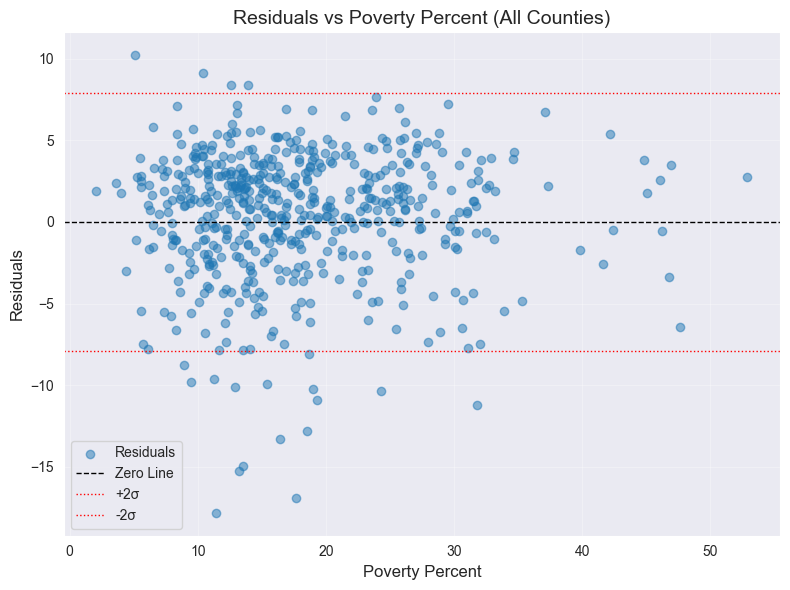

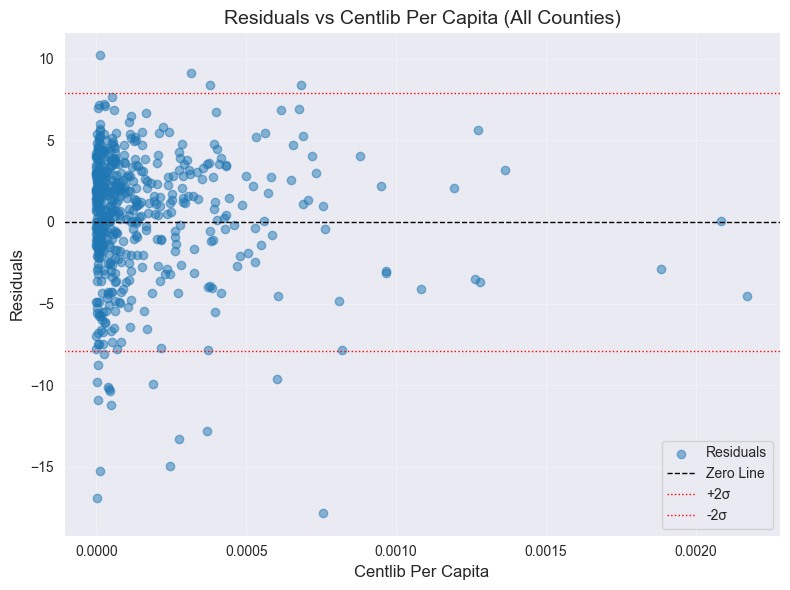

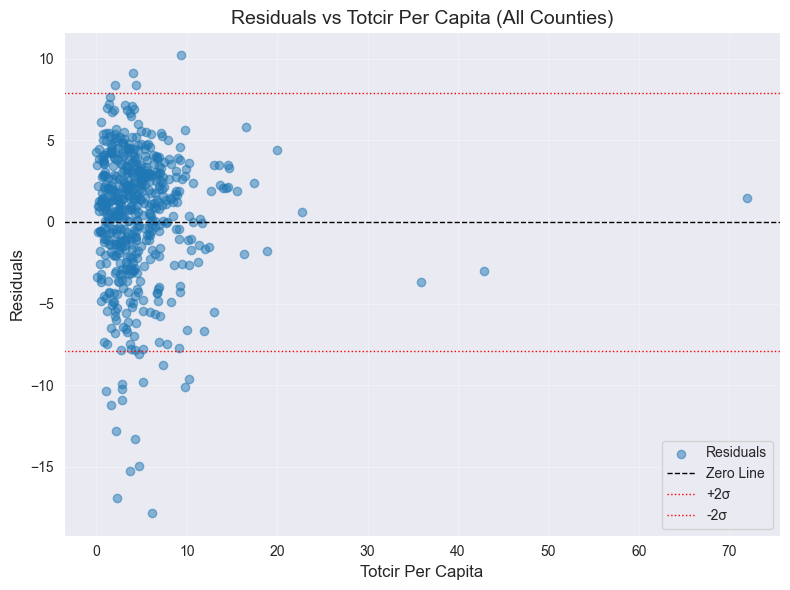

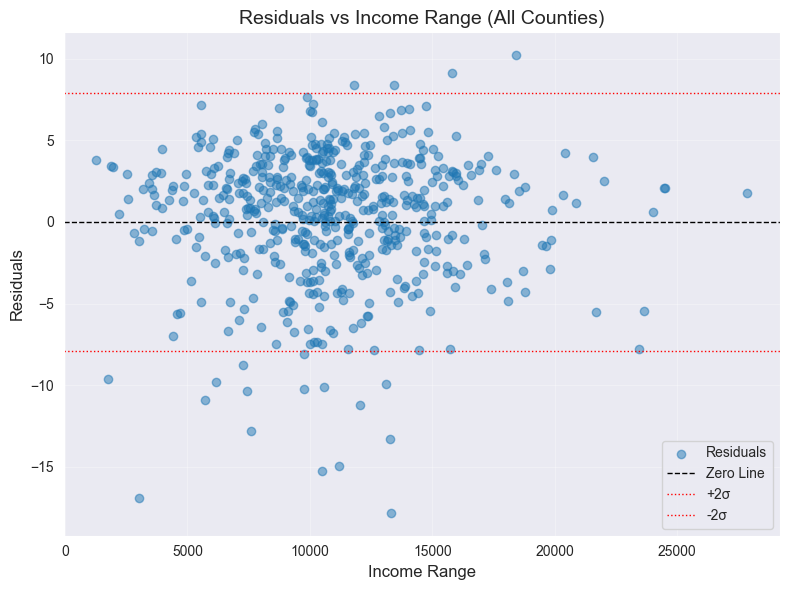

In [29]:
# Variables to plot
selected_vars = ['poverty_percent', 'centlib_per_capita', 'totcir_per_capita', 'income_range', 'visits_per_capita']

# Prepare the residuals DataFrame
test_residuals_df = pd.DataFrame({
    var: analysis_results['data'][var].reset_index(drop=True) for var in selected_vars
})
test_residuals_df['test_residuals'] = pd.Series(analysis_results['test_residuals']).reset_index(drop=True)

# Calculate standard deviation for ±2σ confidence bands
std_dev = test_residuals_df['test_residuals'].std()

# Create a plot for each selected variable
for var in selected_vars:
    plt.figure(figsize=(8, 6))
    plt.scatter(test_residuals_df[var], test_residuals_df['test_residuals'], alpha=0.5, label='Residuals')
    plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Line')
    plt.axhline(2 * std_dev, color='red', linestyle=':', linewidth=1, label='+2σ')
    plt.axhline(-2 * std_dev, color='red', linestyle=':', linewidth=1, label='-2σ')

    # Set titles and labels
    plt.title(f'Residuals vs {var.replace("_", " ").title()} (All Counties)', fontsize=14)
    plt.xlabel(var.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

### errors by county
- analysis of errors by county, of both the training and tests sets
- most predictions of counties perform well, with notable exceptions
- errors may be geographically correlated (e.g. South Texas)

In [30]:
def create_residuals_choropleth_html(analysis_results, residual_type, title, output_file):
    """
    Create a choropleth map for residuals (train or test) and save as an HTML file.
    
    Parameters:
        analysis_results (dict): Dictionary containing residual data.
        residual_type (str): Type of residuals ('train_residuals' or 'test_residuals').
        title (str): Title of the choropleth map.
        output_file (str): Path to save the HTML file.
    """
    # Prepare a DataFrame for the map
    residuals_df = pd.DataFrame({
        'county_code': analysis_results['data']['county_code'],  # County FIPS codes
        'STATE': analysis_results['data']['STATE'],             # State names
        'COUNTY': analysis_results['data']['COUNTY'],           # County names
        'residuals': analysis_results[residual_type]            # Residuals from the analysis
    })

    # Add absolute residuals for visualization
    residuals_df['abs_residuals'] = residuals_df['residuals'].abs()

    # Drop rows where FIPS codes or residuals are missing
    residuals_df = residuals_df.dropna(subset=['county_code', 'residuals'])

    # Load GeoJSON for US counties
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)

    # Create the choropleth map
    fig = px.choropleth(
        residuals_df,
        geojson=counties,        # GeoJSON file for US counties
        locations='county_code', # Column with FIPS codes
        color='abs_residuals',   # Column with absolute residuals
        hover_name='COUNTY',     # Column for hover text
        hover_data={
            'STATE': True,
            'residuals': ':.3f',  # Show residuals with 3 decimal places
            'abs_residuals': ':.3f'
        },
        color_continuous_scale="RdYlGn_r",  # Reversed "RdYlGn" color scheme
        range_color=(0, residuals_df['abs_residuals'].max()),  # Dynamically set range
        scope="usa",             # Show only the USA
        labels={'abs_residuals': 'Absolute Residuals'}  # Legend label
    )

    # Adjust layout
    fig.update_layout(
        title=title,
        margin={"r": 0, "t": 0, "l": 0, "b": 0}
    )

    # Save the map as an HTML file
    pio.write_html(fig, file=output_file)
    print(f"Choropleth map saved as {output_file}")

# Generate and save maps for train and test residuals
create_residuals_choropleth_html(analysis_results, 'test_residuals', 
                                 "Test Set -- USA Absolute Residuals by County (Higher = Red)", 
                                 "test_residuals_map.html")

create_residuals_choropleth_html(analysis_results, 'train_residuals', 
                                 "Train Set -- USA Absolute Residuals by County (Higher = Red)", 
                                 "train_residuals_map.html")


Choropleth map saved as test_residuals_map.html
Choropleth map saved as train_residuals_map.html
